In [7]:
# mount data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import linear regression model
from sklearn.linear_model import LinearRegression
# import regression metrics needed from sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor




In [9]:
# load the dataset
df = pd.read_csv('/content/sales_predictions (3).csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
df.duplicated().any()

# check for any duplicate data

False

In [11]:
df.isnull().sum()

# check for null values in data 

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [12]:
df[df['Item_Weight'].isnull()]

# want to investigate these null values a little 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [13]:
filtering_item_weight = df['Item_Weight']

item_weight_avg = filtering_item_weight.mean()

filtering_item_weight.fillna(item_weight_avg, inplace= True)

df.isna().sum()

filtering_data_size_1 = df['Outlet_Location_Type'] == 'Tier 1'

filtering_data_size_2 = df['Outlet_Location_Type'] == 'Tier 2'

filtering_data_size_3 = df['Outlet_Location_Type'] == 'Tier 3'

outlet_size = df['Outlet_Size']

df.loc[filtering_data_size_1 & (df['Outlet_Size'].isna()), 'Outlet_Size'] = 'Small'

df.loc[filtering_data_size_2 & (df['Outlet_Size'].isna()), 'Outlet_Size'] = 'Medium'

df.loc[filtering_data_size_3 & (df['Outlet_Size'].isna()), 'Outlet_Size'] = 'Large'

df.isnull().sum()


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

this is how we will take care of the null values. Use average weight for tne null values in weight.
If outlet location type tier is 1 then for outlet size that is null make it small. 
 For tier 2 outlet location type if it has outlet size null make it medium

We have the following issue now: outlet location type is a string not an integer. We must be able to convert it to an integer for later when we want to split into training vs testing data and run our analysis. The idea I had was to just turn Tier 1 into 1, Tier 2 into 2 and Tier 3 into 3. 

In [14]:
tier_1 = ['Tier 1'] 
for char in tier_1:
    df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str.replace(char, '1')

tier_2 = ['Tier 2'] 
for char in tier_2:
    df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str.replace(char, '2')

tier_3 = ['Tier 3'] 
for char in tier_3:
    df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str.replace(char, '3')

outlet_ID = ['OUT'] 
for char in outlet_ID:
    df['Outlet_Identifier'] = df['Outlet_Identifier'].str.replace(char, '')



df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,049,1999,Medium,1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,018,2009,Medium,3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,049,1999,Medium,1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,010,1998,Large,3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,013,1987,High,3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,013,1987,High,3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,045,2002,Medium,2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,035,2004,Small,2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,018,2009,Medium,3,Supermarket Type2,1845.5976


We have a number of columns that are still categorical non integer variables. Some will obviously converted into dummy variables in the next step. However asking the question "are all necessary" its hard to find much real meaning or significance of the item_identifier in terms of predictive value or being a correlative factor. Converting it to a dummy variable in particular will also complicate our data set considerably it isnt as easy to just convert that data into dummy variables in a clean easy to understand way as it is some of these other variables. So hence, given all this, Ive decided to just drop the column.

In [15]:
df.drop(columns = 'Item_Identifier', inplace = True)

In [52]:
df['Outlet_Establishment_Year'].nunique()

9

We have a decision here based off the data above. There are basically 9 unique values for Outlet_Establishment_Year. You can make a case that these perhaps could be also transformed into dummy variables. However, there is potential meaning in the numerical values of the years. Meaning 2009 being more recent than 1999 could have actual significance when we use it in a regression model these arent just numbers where there is no meaning in one being greater than the other. So we will keep them and not convert them to dummy variables. 

In [53]:
dummy_df = pd.get_dummies(df, columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type'], drop_first=True)

dummy_df

# we will convert categorical variables into dummy variables

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_Large,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_2,Outlet_Location_Type_3
0,9.300,0.016047,249.8092,049,1999,3735.1380,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,5.920,0.019278,48.2692,018,2009,443.4228,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1
2,17.500,0.016760,141.6180,049,1999,2097.2700,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,19.200,0.000000,182.0950,010,1998,732.3800,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,8.930,0.000000,53.8614,013,1987,994.7052,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,013,1987,2778.3834,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
8519,8.380,0.046982,108.1570,045,2002,549.2850,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
8520,10.600,0.035186,85.1224,035,2004,1193.1136,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
8521,7.210,0.145221,103.1332,018,2009,1845.5976,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1


In [54]:
feature_characteristics = [
                 'Item_Weight',
                 'Item_Visibility',
                 'Item_MRP',
                 'Outlet_Identifier',
                 'Outlet_Establishment_Year',
                ]            
# Get columns for features matrix
df.loc[:, feature_characteristics]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year
0,9.300,0.016047,249.8092,049,1999
1,5.920,0.019278,48.2692,018,2009
2,17.500,0.016760,141.6180,049,1999
3,19.200,0.000000,182.0950,010,1998
4,8.930,0.000000,53.8614,013,1987
...,...,...,...,...,...
8518,6.865,0.056783,214.5218,013,1987
8519,8.380,0.046982,108.1570,045,2002
8520,10.600,0.035186,85.1224,035,2004
8521,7.210,0.145221,103.1332,018,2009


In [20]:
# Convert to numpy array
X = df.loc[:, feature_characteristics].to_numpy()

In [21]:
# Pandas series to convert to NumPy Array
df.loc[:, 'Item_Outlet_Sales']

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [55]:
y = df.loc[:, 'Item_Outlet_Sales'].values

In [23]:
# Import the TTS from sklearn
from sklearn.model_selection import train_test_split
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
reg = LinearRegression()

reg.fit(X_train,y_train)

# we will fit the x and y training data(we will not fit hte testing data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# to predict all values on the training data
train_house = reg.predict(X_train)
# predict the values in the test set
test_house = reg.predict(X_test)

In [27]:
train_score = reg.score(X_train, y_train)
print(train_score)

# run the regression 

0.42933003836579264


In [28]:
test_score = reg.score(X_test, y_test)
print(test_score)

0.4231768324045293


Evaluate your model performance using R^2 on the training set and on the test set.  Is there a difference between model performance on the training data vs the test data?

It looks like the r squared for both is around 0.42. So the performance on the training and test data set are both the same and both have a correlation squared of 42% meaning 
that 100% of the variance in Y can be explained by the variance in X 

In general it is a good thing for these values to be close to each other, the training data r squared you expect to be a bit higher than the test score but too much so is a problem and indicative of over fitting.

Evaluate your model performance using RMSE on the training set and on the test set. This metric is useful because the units will be in the same units as your target vector. RMSE is a measure of how spread out these residuals are. Essentially we can use it to see how concentrated the data is around the line of best fit. 

As you can see the average standard error is quite high. However it is important to note they are similar to each other within 1% of each other for the training vs testing data

In [29]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:', np.sqrt(mean_squared_error(y_train, reg.predict(X_train))))

print('Training RMSE:', np.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

Training RMSE: 1299.566263551154
Training RMSE: 1261.5236892252935


Note: My work for part 6/week 6 basically starts around here 

Project 1 - Final (Core)
This week, you will finalize your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.

Your task is to build tree based models to predict sales and compare evaluation metrics for regression problems.  

Build and evaluate a simple decision tree model.
Build and evaluate a bagged tree model.
Build and evaluate a random forest model.  
You now have tried at least 4 models on this data set (including the regression model from last week).  Compare the performance of your models based on r^2.
Compare the performance of your models based on rmse.  
Overall, which model do you recommend?

In [30]:
# By leaving the parenthesis empty, we are choosing to use all of the default parameters
# So you get the same results, let's set our random_state to the same number
dec_tree = DecisionTreeRegressor(random_state = 42)

In [31]:
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [32]:
train_sales = dec_tree.predict(X_train)
test_sales = dec_tree.predict(X_test)

In [33]:
dec_tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [34]:
# What was the depth of our default tree?
dec_tree.get_depth()

31

In [35]:
# How many leaf nodes?
dec_tree.get_n_leaves()

6271

In [36]:
dec_tree_15 = DecisionTreeRegressor(max_depth = 15, random_state = 42)
dec_tree_15.fit(X_train, y_train)
train_15_score = dec_tree_15.score(X_train, y_train)
test_15_score = dec_tree_15.score(X_test, y_test)
print(train_15_score)
print(test_15_score)

# So clearly 15 is not the best value to set our depth to for analysis. It's probably best we actually investigate what depth value would be best which we will do below 

0.8655758610824908
0.35353768379840467


In [37]:
# List of values to try for max_depth:
max_depth_range = list(range(2, 36)) # will try every value between 2 and 36
# List to store the score for each value of max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train, y_train)
    score = dec_tree.score(X_test, y_test)
    r2.append(score)

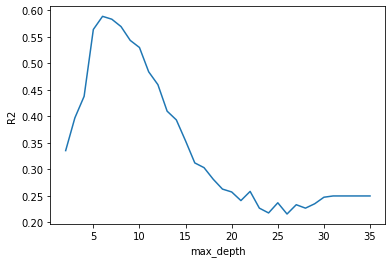

In [38]:
# Visualize which max_depth leads to the highest r2 score
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

based off the graph the optimized value for max depth appears to be around 6

In [39]:
# Let's run the model with our optimized value for max_depth
dec_tree_6 = DecisionTreeRegressor(max_depth = 6, random_state = 42)
dec_tree_6.fit(X_train, y_train)
train_6_score = dec_tree_6.score(X_train, y_train)
test_6_score = dec_tree_6.score(X_test, y_test)
print(train_6_score)
print(test_6_score)

0.6071107160670903
0.5884508206104762


the above are ok r squared values about 58-59% of the variance in outlet sales is accounted for by feature characteristics. Important point is they are similar between the training and testing model.

Below now lets create our random forest regressor model. 

In [60]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, dec_tree_6.predict(X_train))))

print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, dec_tree_6.predict(X_test))))

Training RMSE: 1078.3034974359512
Testing RMSE: 1065.5772326542844


As you can see the average standard error is quite high. However it is important to note they are similar to each other within 1% of each other for the training vs testing data

I want to see what the RMSE for other models we will do below for this data look like in particular before making too many conclusions about these two values 

In [40]:
rf = RandomForestRegressor(random_state = 42)

In [41]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [42]:
rf.predict(X_test)

array([ 702.871744,  851.644754,  882.777562, ..., 3458.145226,
       2097.895852, 2337.870146])

In [43]:
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print(rf_train_score)
print(rf_test_score)

0.9364527458765458
0.5547545029346236


using the random model interestingly now the r squared of the training data becomes alot higher. These results where the training is alot higher than the test score data are indicative of over fitting. 

In [61]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, rf.predict(X_train))))

print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

Training RMSE: 433.6649440785544
Testing RMSE: 1108.342101474792


So above as you can see we did the RMSE analysis for the random tree model. Not surprisingly big gap in the Training vs Testing RMSE values. Which is not ideal 

Now we can do bag regression

In [44]:
bagreg = BaggingRegressor(random_state = 42)

In [45]:
bagreg.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=42, verbose=0,
                 warm_start=False)

In [46]:
bagreg.predict(X_test)

array([ 631.77762, 1026.26412,  778.58652, ..., 2941.97046, 2294.41338,
       2394.08364])

In [47]:
bagreg_train_score = bagreg.score(X_train, y_train)
bagreg_test_score = bagreg.score(X_test, y_test)
print(bagreg_train_score)
print(bagreg_test_score)

0.9176977628444358
0.5346867621260618


We have similar issues as with the random tree regressor(not shocking). R squared of the training data is way higher than the testing data to a degree that is indicative of over fitting. 

In [62]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, bagreg.predict(X_train))))

print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, bagreg.predict(X_test))))

Training RMSE: 493.5279376543256
Testing RMSE: 1133.0439775268967


Not surprising but again big gap in RMSE of training vs testing data indicative of potential over fitting. 

To get back to the prompt: You now have tried at least 4 models on this data set (including the regression model from last week). Compare the performance of your models based on r^2. Compare the performance of your models based on rmse.
Overall, which model do you recommend?

The r squared values for the simple decision tree model are in line with showing some correlation between the variables tested here(testing characteristics vs item prices)(0.58-0.59) and has RMSE values that are also similar to each other. As stated above the 2 other models we made the random and the bagged have issues of overfitting potentially. The model from last week has an r squared of around 0.42 which is ok but the 0.59 is indicative of a stronger relationship between X and Y. Hence its probably best to recommend it. 